In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
import lsst.sims.featureScheduler as fs
from lsst.sims.utils import _hpid2RaDec
from scipy.optimize import minimize, basinhopping

In [2]:
nside = 128
current_obs = np.ones(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
out =  np.where( (ra < np.radians(45)) | (ra > np.radians(55.)))
current_obs[out] = hp.UNSEEN
current_obs[np.where(np.abs(dec) > np.radians(7.))] = hp.UNSEEN
mask = np.where(current_obs == hp.UNSEEN)

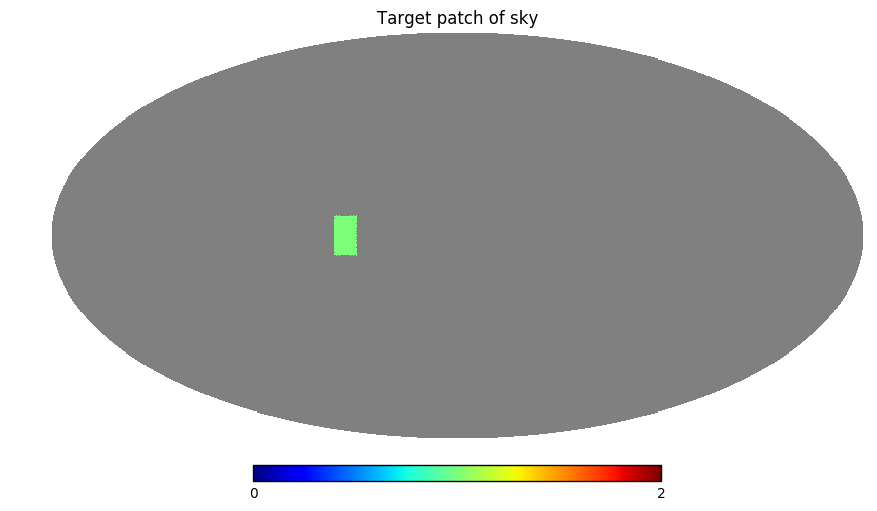

In [3]:
hp.mollview(current_obs, title='Target patch of sky')

In [4]:
hpc = fs.hpmap_cross(nside=nside)
hpc.set_map(current_obs)
print hpc([np.radians(50), np.radians(0.), 0.])

0.552786885246


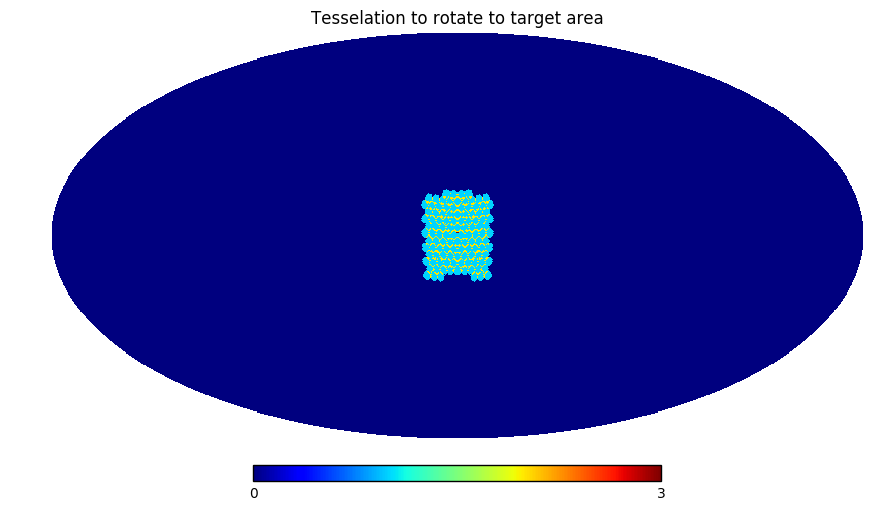

In [5]:
# Make a quick map of the full tesselation
hpc.set_map(current_obs*0+1)
p1, p2, full_map = hpc([0,0,0], return_pointings_map=True)
hp.mollview(full_map, title='Tesselation to rotate to target area')


hpc.set_map(current_obs)

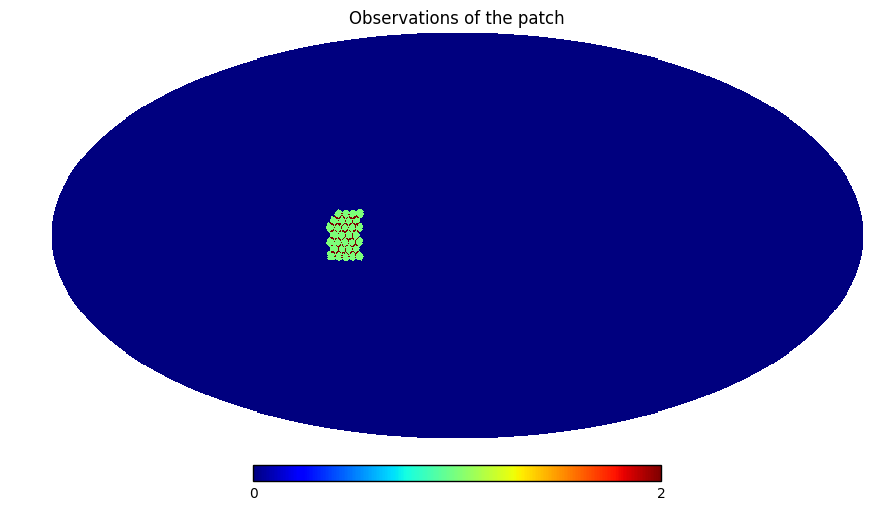

In [6]:
p1, p2, obs_map = hpc([np.radians(50.), 0., 0.], return_pointings_map=True)
hp.mollview(obs_map, title='Observations of the patch')

In [7]:
p1.size

31

In [8]:
hpc.inmap = obs_map +0.
hpc.inmap[mask] = hp.UNSEEN

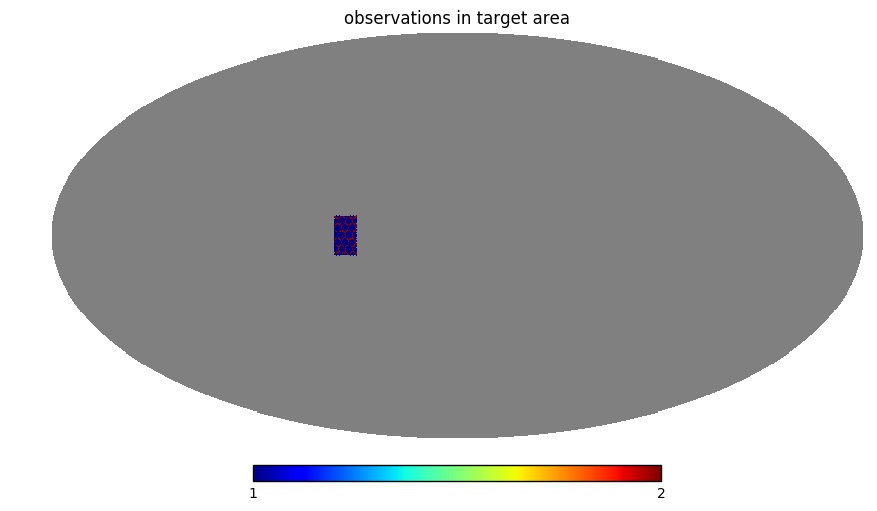

In [9]:
hp.mollview(hpc.inmap, title='observations in target area')

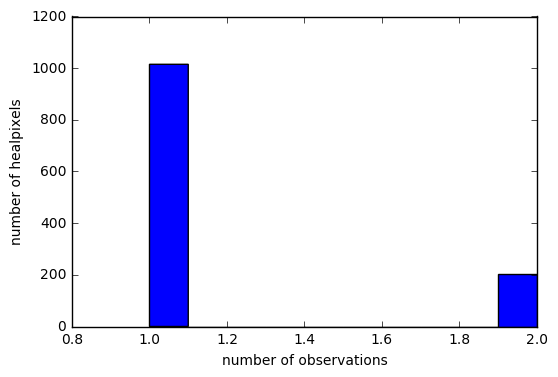

In [10]:
good = np.where(obs_map > 0)
plt.hist(obs_map[good])
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [11]:
hpc([np.radians(50.), np.radians(-1.), 0.])

0.60357142857142854

In [12]:
# find the next best set of pointings that cover the area and minimize the cross-correlation
ack = hpc.minimize()

In [13]:

print 'best fit rotations = ', np.degrees(ack)
print 'best-fit cross-correlation', hpc(ack)
print 'check that cross-correlation goes up if we shift best-fit', hpc(ack-.001)
print 'another check', hpc([ack[0], ack[1], np.pi/4])

best fit rotations =  [  5.08290476e+01  -7.77259518e-03   1.18066587e+02]
best-fit cross-correlation 0.601796407186
check that cross-correlation goes up if we shift best-fit 0.604901374776
another check 0.624263839812


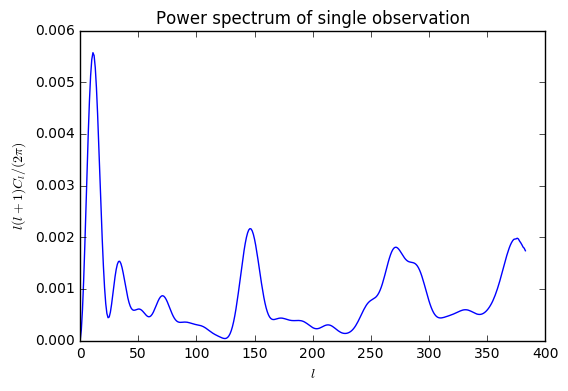

In [14]:
masked_map = obs_map.copy() +0.
#masked_map[mask] = hp.UNSEEN
cl = hp.anafast(masked_map)
ell = np.arange(np.size(cl))
plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi)
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
plt.title('Power spectrum of single observation')

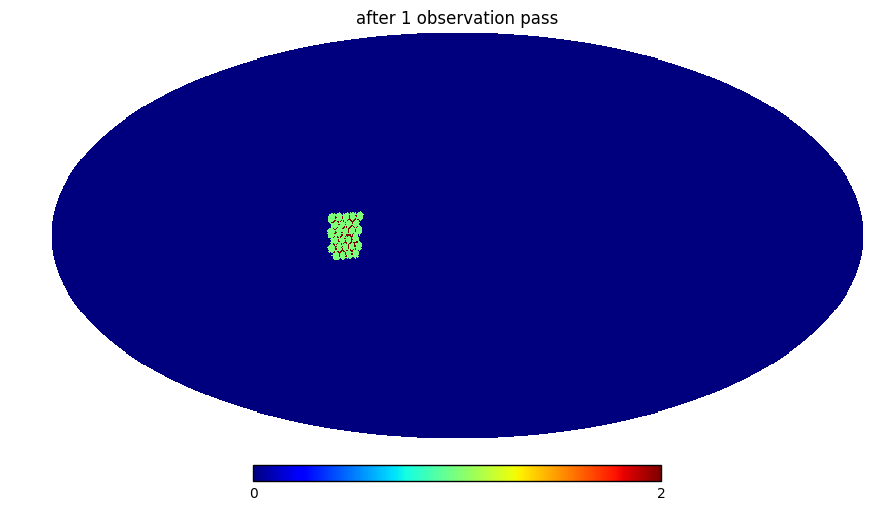

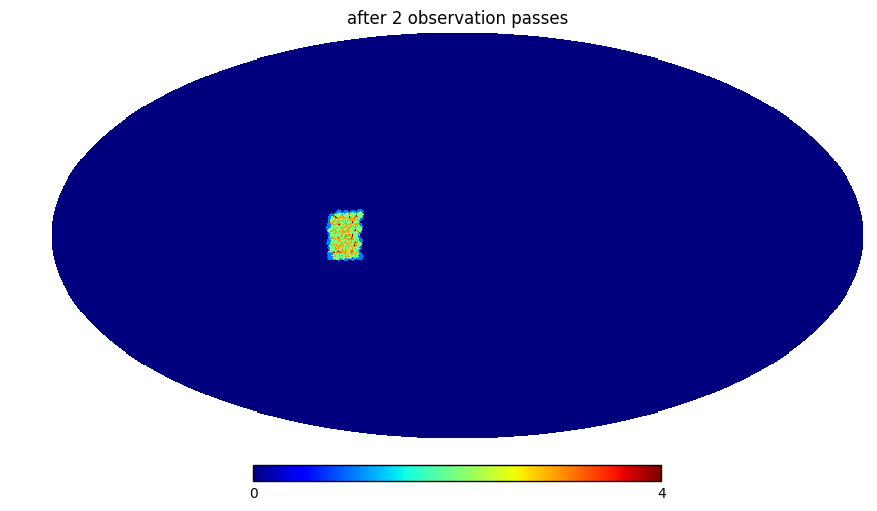

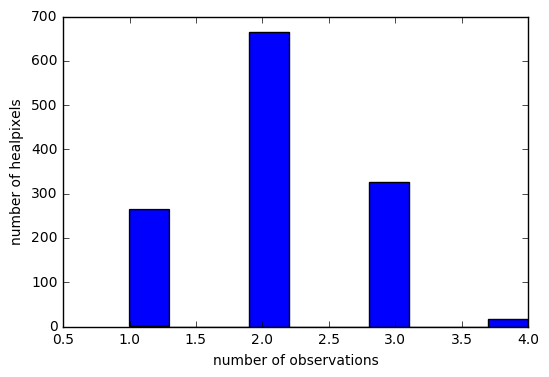

In [15]:
obs_ra, obs_dec, single_map = hpc(ack, return_pointings_map=True)
hp.mollview(single_map, title='after 1 observation pass')
hp.mollview(single_map + obs_map, title='after 2 observation passes')
good = np.where(obs_map+single_map > 0)
plt.figure()
plt.hist(single_map[good] + obs_map[good])
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [16]:
# Let's observe the patch 10 times!
bfs = []
for i in np.arange(10):
    best_fit = hpc.minimize()
    bfs.append(best_fit)
    p1, p2, obs_map2 = hpc(best_fit, return_pointings_map=True)
    obs_map += obs_map2
    hpc.inmap = obs_map +0.
    hpc.inmap[mask] = hp.UNSEEN

[ 48.97442351   1.44124751   3.00610452]


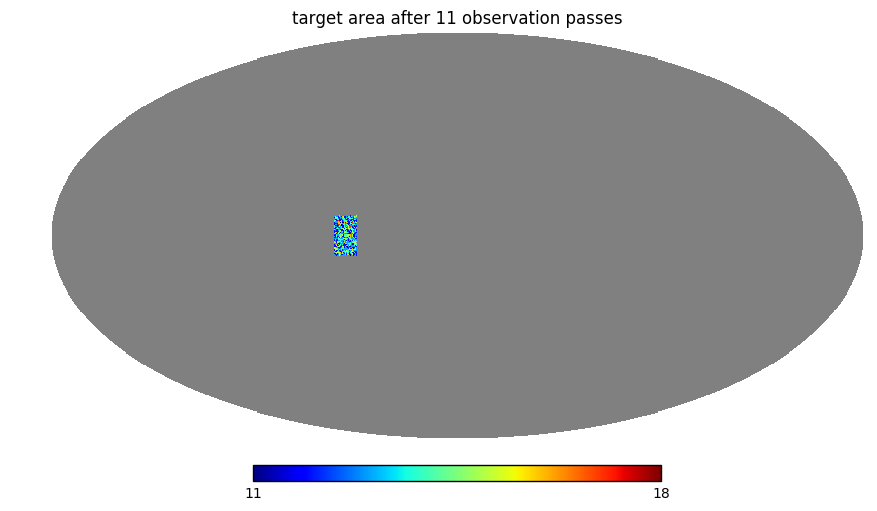

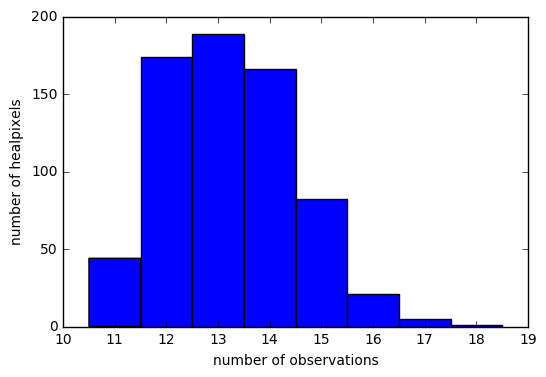

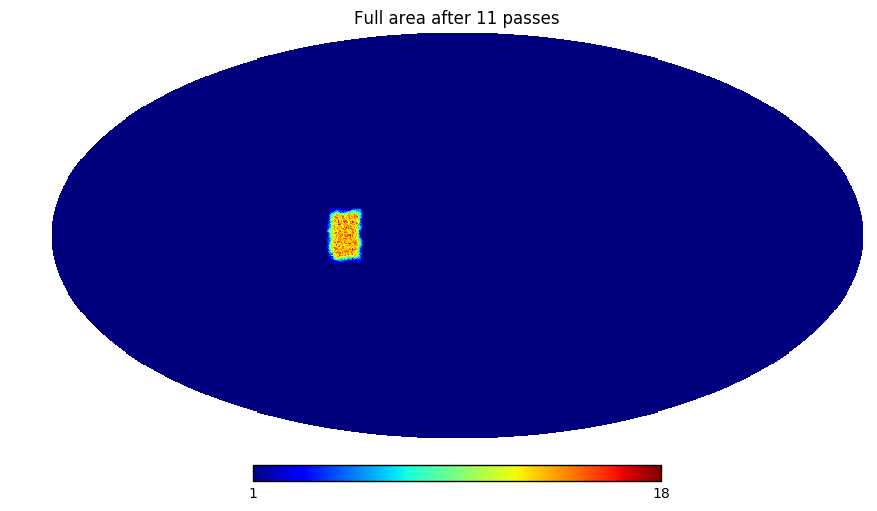

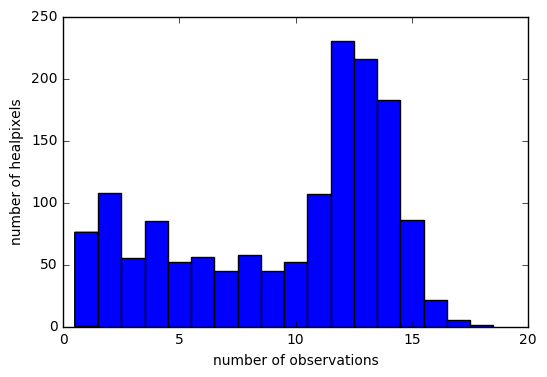

In [17]:
print np.degrees(best_fit)
hp.mollview(hpc.inmap, title='target area after 11 observation passes')
plt.figure()
good = np.where(hpc.inmap != hp.UNSEEN) #np.where(obs_map > 0)
plt.hist(obs_map[good], bins=np.arange(obs_map[good].min(),obs_map[good].max()+2,1 )-.5)
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')
hp.mollview(obs_map, min=1, title='Full area after 11 passes')
plt.figure()
good = np.where(obs_map > 0) #np.where(obs_map > 0)
plt.hist(obs_map[good], bins=np.arange(obs_map[good].min(),obs_map[good].max()+2,1 )-.5)
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [18]:
# look at all the best fit values
np.degrees(bfs)

array([[  5.08290476e+01,  -7.77259518e-03,   1.18066587e+02],
       [  5.05211365e+01,  -1.14413853e+00,   6.83048935e+01],
       [  4.97262688e+01,   1.34614490e+00,   3.30393351e+00],
       [  5.02064793e+01,   1.24754230e+00,   3.16004372e+01],
       [  5.02413573e+01,   3.27408756e-01,   4.41603951e+01],
       [  4.91383574e+01,   9.35960390e-01,   1.63740535e+01],
       [  4.94333690e+01,   5.31367011e-01,   3.46780987e+01],
       [  5.02169404e+01,   7.85768904e-02,   6.86477632e+01],
       [  5.12337101e+01,   6.42189790e-01,   6.82990479e+01],
       [  4.89744235e+01,   1.44124751e+00,   3.00610452e+00]])

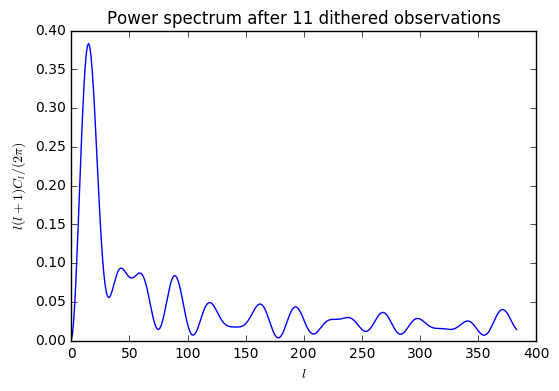

In [19]:
masked_map = obs_map.copy() +0.
masked_map[mask] = hp.UNSEEN
cl = hp.anafast(masked_map)
ell = np.arange(np.size(cl))
plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi)
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
plt.title('Power spectrum after 11 dithered observations')